In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [2]:
engage_df = pd.read_csv('takehome_user_engagement.csv', parse_dates=True)
engage_df.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [3]:
users_df = pd.read_csv('takehome_users.csv', encoding='ISO-8859-1', parse_dates=True)
users_df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [4]:
engage_df['time_stamp'] = pd.to_datetime(engage_df['time_stamp'])
engage_df = engage_df.set_index('time_stamp', drop= True)

In [5]:
# Define a function to return whether a user has been active within any 7 day period
# This is defined by if a user has logged on three seperate days in at least one 7 day period

def label_adopted(x):    
    df_temp = engage_df.loc[engage_df['user_id'] == x] 
    df_temp = df_temp.resample('D').mean().dropna() 
    adopted = 0
    for i in range(len(df_temp)-2): 
        if df_temp.index[i + 2] - df_temp.index[i] <= timedelta(days=7): 
            adopted = 1
            break
        else:
            adopted = 0
    return adopted

In [6]:
# Apply our function to user_df to label users as adopted or not 
users_df['adopted_user'] = users_df['object_id'].apply(label_adopted)

In [7]:
print(sum(users_df['adopted_user']))
print('Percentage of Adopted Users: {}%'.format(sum(users_df['adopted_user'])/len(users_df['adopted_user'])*100))

1656
Percentage of Adopted Users: 13.8%


We found that 1656 users identify as an adopted user. This is 13.8% of the total users

Now we need to do some more cleaning of the data before we can create our classifier model.
Once we have our model created and tuned we will find what the most important features are for a user to adopt the product.

In [8]:
users_df['creation_time'] = pd.to_datetime(users_df['creation_time'])

In [9]:
# last_session_creation time is a unix timestamp, we need to convert this to datetime format
users_df['last_session_creation_time'] = users_df['last_session_creation_time'].map(lambda data: 
                                    datetime.fromtimestamp(int(data)).strftime('%Y-%m-%d %H:%M:%S'), na_action='ignore')

In [10]:
users_df['last_session_creation_time'] = pd.to_datetime(users_df['last_session_creation_time'])

In order to gather more information out of the data we are creating a new column called active_time.
To get this we simply subtract creation_time from the last_session_creation_time. 
Finally we will convert this from days format into seconds format in order to give us more disertion.

In [11]:
users_df['active_time'] = users_df['last_session_creation_time'] - users_df['creation_time']

In [12]:
users_df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user,active_time
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-21 22:53:30,1,0,11,10803.0,0,-1 days +19:00:00
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-30 22:45:04,0,0,1,316.0,1,135 days 19:00:00
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 18:14:52,0,0,94,1525.0,0,-1 days +19:00:00
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 03:09:28,0,0,1,5151.0,0,0 days 19:00:00
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 04:14:20,0,0,193,5240.0,0,4 days 18:00:00


In [13]:
users_df['active_time'] = [x.total_seconds() for x in users_df['active_time']]

In [14]:
users_df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user,active_time
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-21 22:53:30,1,0,11,10803.0,0,-18000.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-30 22:45:04,0,0,1,316.0,1,11732400.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 18:14:52,0,0,94,1525.0,0,-18000.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 03:09:28,0,0,1,5151.0,0,68400.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 04:14:20,0,0,193,5240.0,0,410400.0


Another useful data point to be explored is the email domain of the user. 
This might be a factor in determining which users adopt the product. 
We will create a new column of the top 5 most popular email domains, then label them as rare for users with a different email domain.

In [15]:
users_df['email_domain'] = [x.split('@')[1] for x in users_df['email']]
top5_emails = users_df['email_domain'].value_counts()
top5_emails = top5_emails.head()

In [16]:
top5_emails.head()

gmail.com         3562
yahoo.com         2447
jourrapide.com    1259
cuvox.de          1202
gustr.com         1179
Name: email_domain, dtype: int64

In [17]:
users_df['email_domain'] = [x if x in top5_emails else 'rare' for x in users_df['email_domain']]

In [18]:
users_df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user,active_time,email_domain
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-21 22:53:30,1,0,11,10803.0,0,-18000.0,yahoo.com
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-30 22:45:04,0,0,1,316.0,1,11732400.0,gustr.com
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 18:14:52,0,0,94,1525.0,0,-18000.0,gustr.com
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 03:09:28,0,0,1,5151.0,0,68400.0,yahoo.com
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 04:14:20,0,0,193,5240.0,0,410400.0,yahoo.com


In [19]:
users_df['invited_by_user_id'] = users_df['invited_by_user_id'].fillna(0)
users_df['last_session_creation_time'] = users_df['last_session_creation_time'].fillna(0)

Final clean up of our dataframe, removing columns we don't need (object_id, creation_time, name, email, and last_session_creation_time).
We create our freature_df to hold this data and then encode our categorical features using LabelEncoder.

In [20]:
feature_df = users_df.iloc[:,4:]
feature_df = feature_df.drop('last_session_creation_time', axis=1)
feature_df['active_time'] = feature_df['active_time'].fillna(0)
feature_df.head()

,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user,active_time,email_domain
0,GUEST_INVITE,1,0,11,10803.0,0,-18000.0,yahoo.com
1,ORG_INVITE,0,0,1,316.0,1,11732400.0,gustr.com
2,ORG_INVITE,0,0,94,1525.0,0,-18000.0,gustr.com
3,GUEST_INVITE,0,0,1,5151.0,0,68400.0,yahoo.com
4,GUEST_INVITE,0,0,193,5240.0,0,410400.0,yahoo.com


In [21]:
gle = LabelEncoder()
creation_labels = gle.fit_transform(users_df['creation_source'])
feature_df['creation_source'] = creation_labels

org_id_labels = gle.fit_transform(users_df['org_id'])
feature_df['org_id'] = org_id_labels

invited_labels = gle.fit_transform(users_df['invited_by_user_id'])
feature_df['org_id'] = invited_labels

email_labels = gle.fit_transform(users_df['email_domain'])
feature_df['email_domain'] = email_labels

In [22]:
feature_df.head()

,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user,active_time,email_domain
0,0,1,0,2325,10803.0,0,-18000.0,5
1,1,0,0,56,316.0,1,11732400.0,2
2,1,0,0,298,1525.0,0,-18000.0,2
3,0,0,0,1104,5151.0,0,68400.0,5
4,0,0,0,1127,5240.0,0,410400.0,5


In [23]:
X = feature_df.drop('adopted_user', axis=1)
y = feature_df['adopted_user']

X_train, y_train, X_test, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [24]:
rf = RandomForestClassifier(n_estimators=100)

rf.fit(X_train, X_test)

print('Classifier Score: {}%'.format(rf.score(y_train, y_test).round(4)*100))

Classifier Score: 97.22%


In [25]:
# Print out classification report
y_pred = rf.predict(y_train)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      3407
           1       0.92      0.87      0.90       553

    accuracy                           0.97      3960
   macro avg       0.95      0.93      0.94      3960
weighted avg       0.97      0.97      0.97      3960



RandomForestClassifier is better at intrinsically describing data over predictive power, so these results are very impressive.
What this indicates is that the classifier is not overfit, making whatever feature importance it has assigned much more valid.

In [26]:
feature_importance = pd.DataFrame(list(zip(X.columns, rf.feature_importances_)), columns=['Feature','Importance'])
feature_importance = feature_importance.sort_values(ascending=False, by='Importance')
feature_importance.head(5)

,Feature,Importance
5,active_time,0.900120
4,invited_by_user_id,0.032602
3,org_id,0.031970
6,email_domain,0.016023
0,creation_source,0.010246


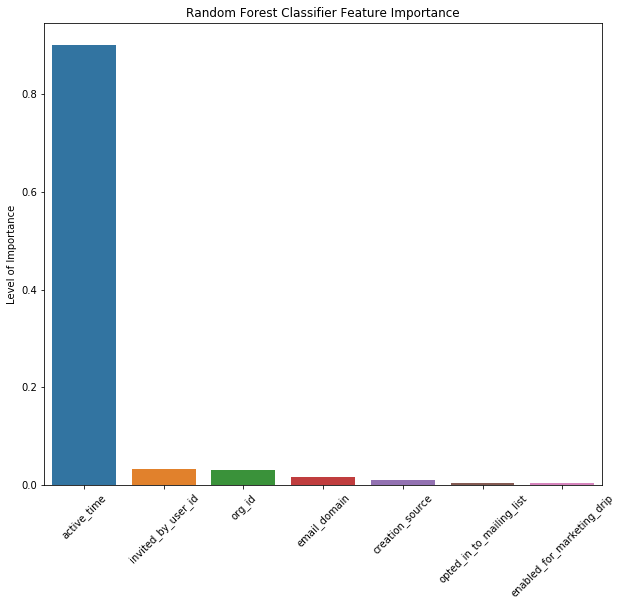

In [27]:
plt.figure(figsize=(10,8.5))
sns.barplot(x=list(feature_importance['Feature']), y=(feature_importance['Importance']))
plt.title('Random Forest Classifier Feature Importance')
plt.ylabel('Level of Importance')
plt.xticks(rotation=45)
plt.show()

According to this analysis, RandomForestClassifer identified active_time to be the greatest indicator of whether they became an adopted user.
Based on these findings, I would recommend exploring ways to encourage users to spend more time logged into the product. The least important features are opted_in_to_mailing_list and enabled_for_market_drip. This seems to suggest that the marketing for the product is having almost no effect on converting users to adopted users. The marketing should consider adjusting its strategy to focus on incentivizing users to spend more time logged into the product.